In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import h5py
import numpy as np
import scipy.optimize
import jax.numpy as jnp

import proplot as pplt

In [2]:
with h5py.File("/Users/beckermr/Desktop/sompz_y6_imsim_400Tile.hdf5") as d:
    nzs = {}
    for _bin in range(4):
        nzs[_bin] = d[f"catalog/sompz/pzdata/bin{_bin}"][:]
    zlow = d["catalog/sompz/pzdata/zlow"][:]
    zhigh = d["catalog/sompz/pzdata/zhigh"][:]
    z = (zlow + zhigh)/2
    dz = z[1] - z[0]

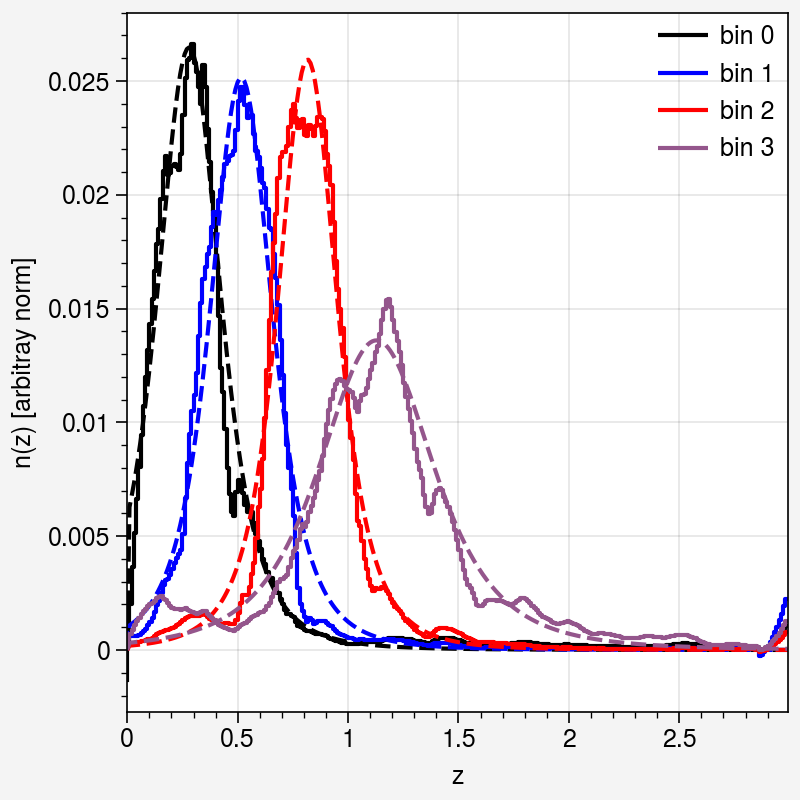

In [3]:
from des_y6_nz_modeling import fit_nz_data_for_template_params, mstudt_nrm, ZVALS

params = fit_nz_data_for_template_params(nzs)

fig, axs = pplt.subplots(figsize=(4, 4))

for i, col in enumerate(["black", "blue", "red", "purple"]):
    popt = params[i]
    axs.plot(z, nzs[i] / np.sum(nzs[i]), drawstyle="steps", color=col, label=f"bin {i}")
    axs.plot(z, mstudt_nrm(z, *popt), linestyle="dashed", color=col)

axs.format(xlabel="z", ylabel="n(z) [arbitray norm]")
axs.legend(loc="ur", frameon=False, ncols=1)

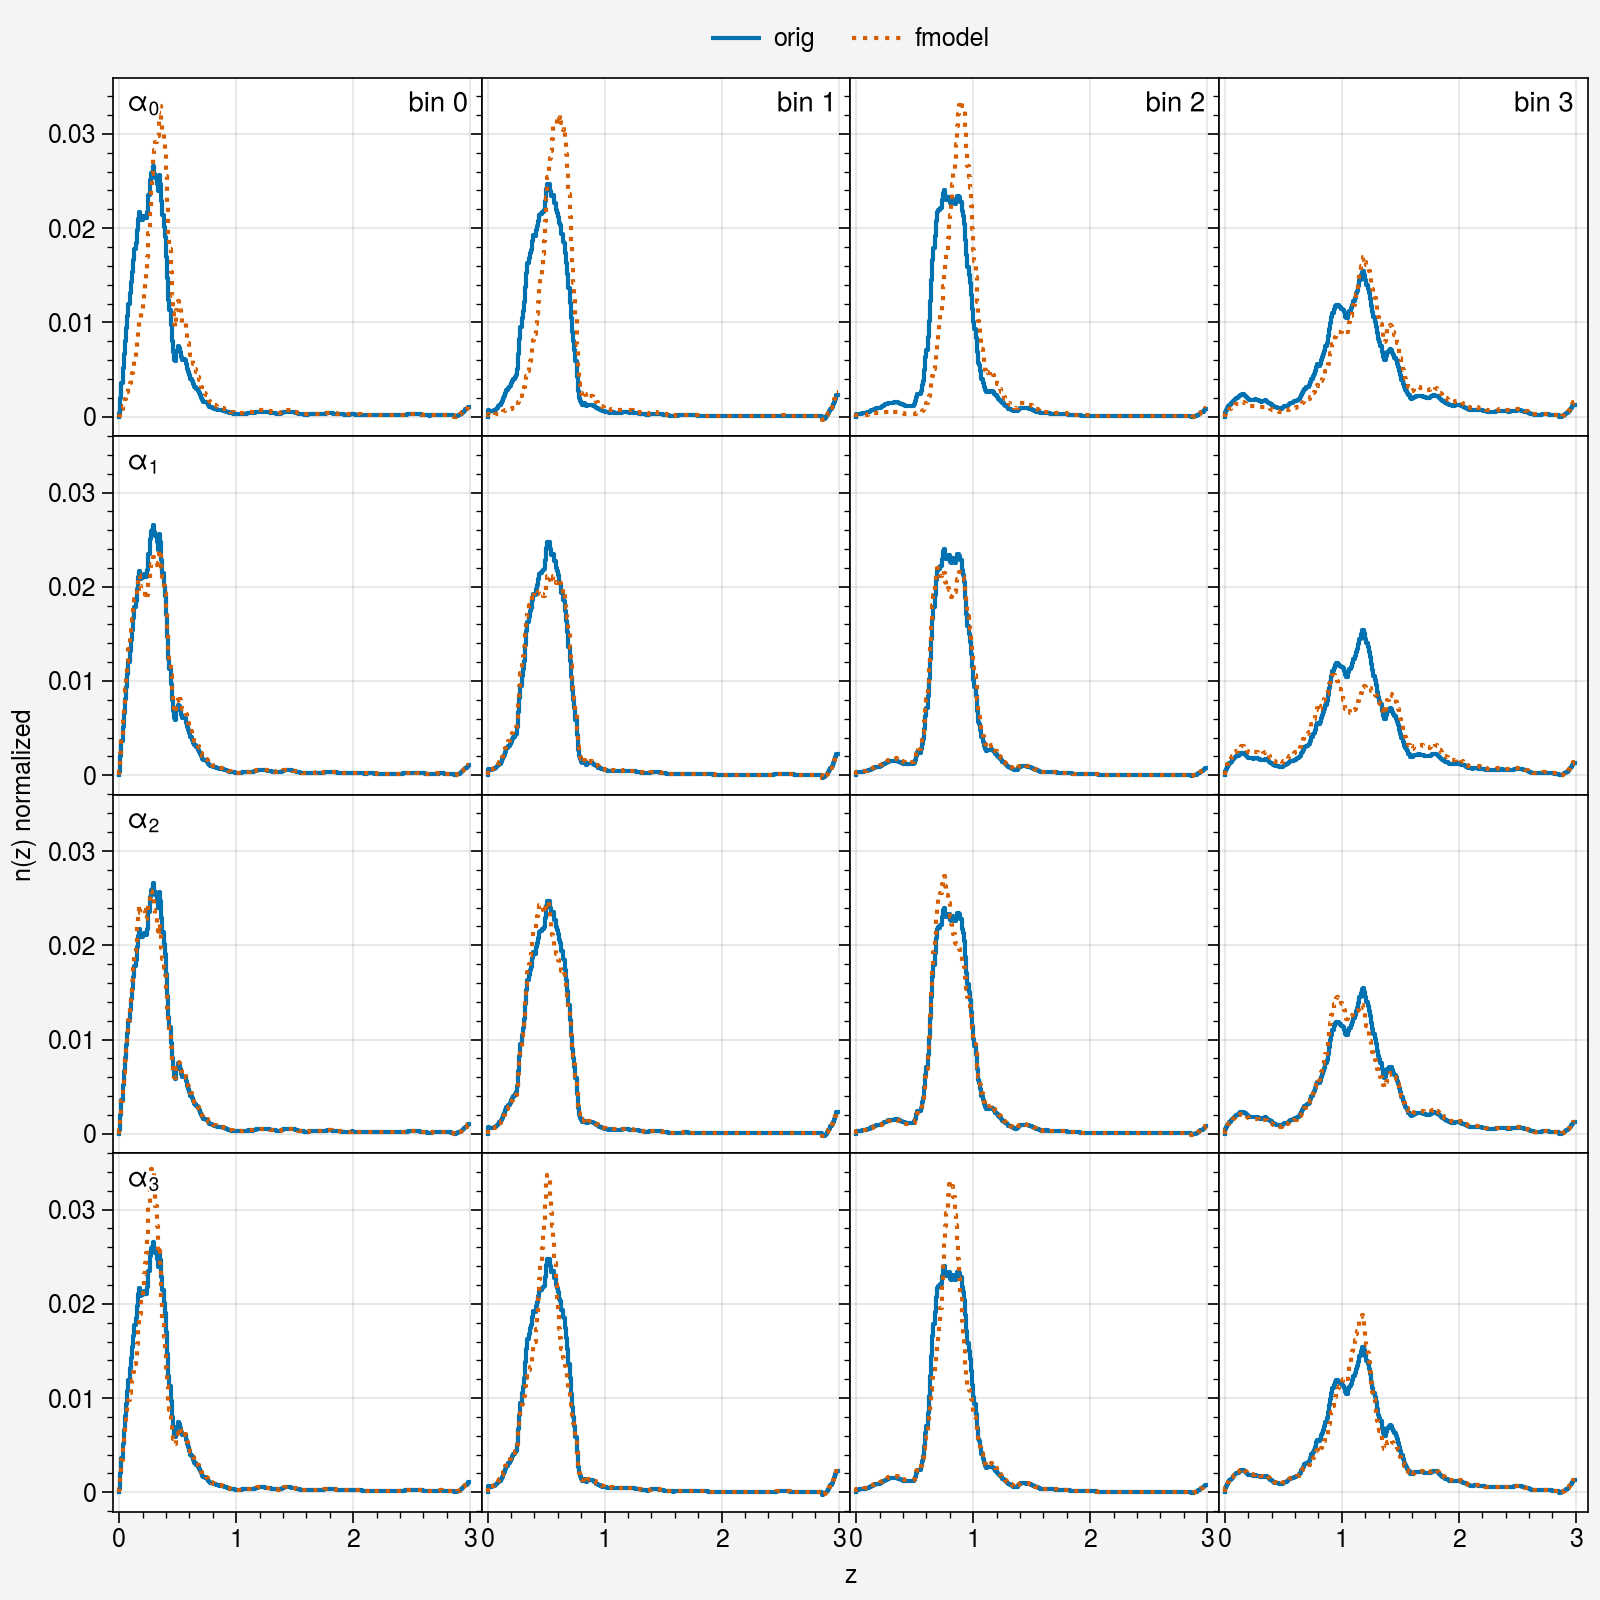

In [4]:
from des_y6_nz_modeling import fmodel_mstudt4

scales = np.array([1e-1, 5e-3, 1e-3, 5e-4])

fig, axs = pplt.subplots(ncols=4, nrows=4, figsize=(8, 8), share=4, wspace=0, hspace=0)

for i in range(4):
    for row in range(4):
        ax = axs[row, i]
        avec = np.zeros(4)
        avec[row] = scales[row]
        if i == 3 and row > 0:
            avec *= 10

        nzi = nzs[i].astype(np.float64).copy()
        nzi[0] = 0.0
        nzi = nzi / np.sum(nzi)
        stud_params = params[i]

        morig = ax.plot(z, nzi, drawstyle="steps", label="orig")

        fac = 1.0 + fmodel_mstudt4(z, 0.0, avec[0], avec[1], avec[2], avec[3], stud_params[0], stud_params[1])
        nzi_fmodel = nzi * fac
        nzi_fmodel /= np.sum(nzi_fmodel)
        mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # fac = 1.0 + fmodel_stud4(z, 0.0, 0e-1, 0e-3, 0e-3, 0e-4, stud_params[0], stud_params[1])
        # nzi_fmodel = nzi * fac
        # nzi_fmodel /= np.sum(nzi_fmodel)
        # mmod = ax.plot(z, nzi_fmodel, drawstyle="steps", linestyle="dotted", label="fmodel")

        # axs.plot(z, fac, linestyle="dotted")
        ax.format(xlim=(-0.05, 3.1))
        if row == 0:
            ax.format(urtitle=f"bin {i}")
        if i == 0:
            ax.format(ultitle=f"$\\alpha_{row}$", ylabel="n(z) normalized")
        if row == 3:
            ax.format(xlabel="z")

fig.legend([morig, mmod], loc="t", frameon=False, ncols=3)

## Try a Simple Non-tomographic Fit

In [5]:
import io

data = """\
alpha zlow zhigh N_mean N_cov
0 0.0 0.3 0.16604946555161076 2.3922677165562107e-06
1 0.3 0.6 0.258896569024523 2.835851049983516e-06
2 0.6 0.9 0.20357638602293907 3.1823746370901463e-06
3 0.9 1.2 0.09642206416492924 1.788271317955803e-06
4 1.2 1.5 0.03060837124349315 9.921730840757012e-07
5 1.5 1.8 0.007998784283116315 3.544094072273322e-07
6 1.8 2.1 0.0035519712436788663 2.459260788414852e-07
7 2.1 2.4 0.0024379335570187937 1.5620099170474468e-07
8 2.4 2.7 0.0015880945522460926 1.6736817370043318e-07
9 2.7 6.0 0.0016014348772042115 2.426033233807593e-07
"""
sdata = np.genfromtxt(io.StringIO(data), names=True)

1.0


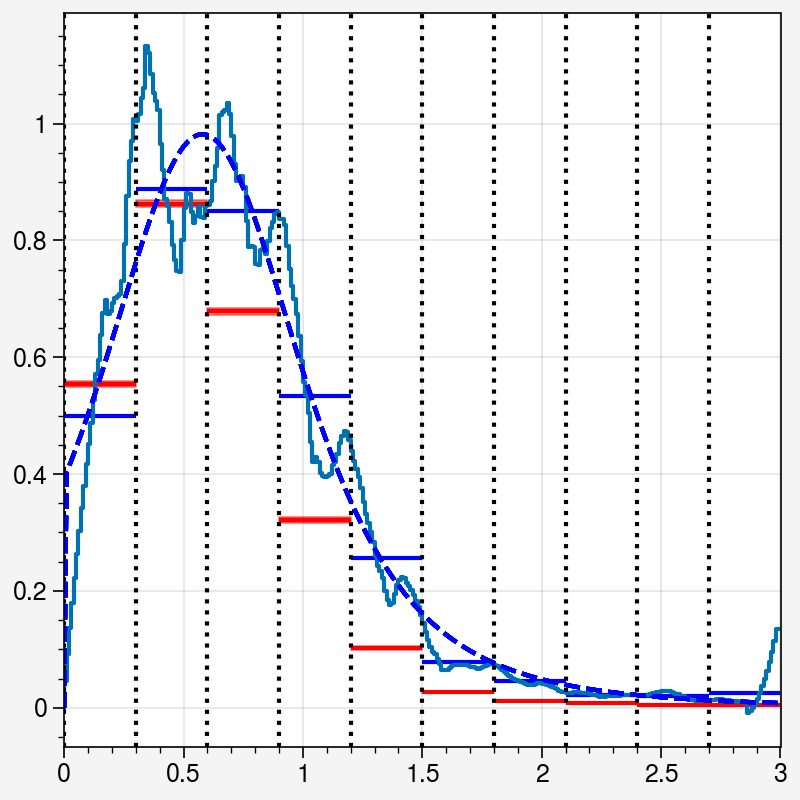

In [6]:
from des_y6_nz_modeling import DZ

nz_nontomo = nzs[0].astype(np.float64)
for i in range(1, 4):
    nz_nontomo += nzs[i].astype(np.float64)
nz_nontomo /= 4.0
nz_nontomo[0] = 0

nzs_nontomo = {0: nz_nontomo}
params_nontomo = fit_nz_data_for_template_params(nzs_nontomo)

nz_nontomo = nz_nontomo / jnp.trapezoid(nz_nontomo, dx=DZ)
print(jnp.trapezoid(nz_nontomo, dx=DZ))

fig, axs = pplt.subplots(figsize=(4, 4))
ax = axs[0, 0]
ax.plot(ZVALS, nz_nontomo, drawstyle="steps", label="nontomo")
for i in range(10):
    msk = sdata["alpha"] == i
    bin_zmin = sdata["zlow"][msk][0]
    bin_zmax = min(sdata["zhigh"][msk][0], 3.0)
    bin_dz = bin_zmax - bin_zmin
    ax.hlines(sdata["N_mean"][msk] / bin_dz, sdata["zlow"][msk], min(sdata["zhigh"][msk], 3.0), color="red")
    ax.fill_between(
        np.array([bin_zmin, bin_zmax]),
        sdata["N_mean"][msk] / bin_dz - np.sqrt(sdata["N_cov"][msk]) / bin_dz,
        sdata["N_mean"][msk] / bin_dz + np.sqrt(sdata["N_cov"][msk]) / bin_dz,
        color="red",
        alpha=0.5,
    )
    ax.axvline(bin_zmin, color="black", linestyle="dotted")

    msk = (ZVALS >= bin_zmin) & (ZVALS < bin_zmax)
    ng_val = jnp.trapezoid(nz_nontomo[msk], dx=DZ) / bin_dz
    ax.hlines(ng_val, bin_zmin, bin_zmax, color="blue")

    ax.plot(ZVALS, mstudt_nrm(ZVALS, *params_nontomo[0]) / DZ, linestyle="dashed", color="blue")

## Try numpyro

In [7]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/beckermr/mambaforge/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
from des_y6_nz_modeling import fmodel_mstudt4, gmodel_template_cosmos, ZVALS, ZBIN_LOW, ZBIN_HIGH, DZ


def model(mu=None, sigma=None, nz=None, N_mean=None, N_cov=None):
    assert mu is not None
    assert sigma is not None
    assert nz is not None
    assert N_mean is not None
    assert N_cov is not None

    pwidth = 0.001
    a0 = numpyro.sample("a0", dist.Normal(0.0, pwidth))
    a1 = numpyro.sample("a1", dist.Normal(0.0, pwidth))
    a2 = numpyro.sample("a2", dist.Normal(0.0, pwidth))
    a3 = numpyro.sample("a3", dist.Normal(0.0, pwidth))
    a4 = numpyro.sample("a4", dist.Normal(0.0, pwidth))
    g = numpyro.sample("g", dist.Normal(0.0, pwidth))

    fmod = fmodel_mstudt4(ZVALS, a0, a1, a2, a3, a4, mu, sigma)
    gmod = g * gmodel_template_cosmos()
    ngamma = (1.0 + fmod) * nz + gmod
    ngamma = jnp.clip(ngamma, 0.0, jnp.inf)

    for zlow, zhigh in zip(ZBIN_LOW, ZBIN_HIGH):
        msk = (ZVALS >= zlow) & (ZVALS < zhigh)
        ng_val = jnp.trapezoid(ngamma[msk], dx=DZ)
        numpyro.sample(f"N_{zlow}_{zhigh}", dist.Normal(ng_val, jnp.sqrt(N_cov)), obs=N_mean)

In [58]:
from jax import random

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_,
    mu=params_nontomo[0][0],
    sigma=params_nontomo[0][1],
    nz=nz_nontomo,
    N_mean=sdata["N_mean"],
    N_cov=sdata["N_cov"] * 100,
)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1678.53it/s, 7 steps of size 1.99e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     -0.04      0.00     -0.04     -0.04     -0.04   2407.33      1.00
        a1     -0.01      0.00     -0.01     -0.01     -0.01   2406.36      1.00
        a2      0.05      0.00      0.05      0.04      0.05   2418.06      1.00
        a3     -0.00      0.00     -0.00     -0.00     -0.00   2728.43      1.00
        a4     -0.01      0.00     -0.01     -0.01     -0.01   2900.88      1.00
         g     -0.04      0.00     -0.04     -0.04     -0.04   2267.71      1.00

Number of divergences: 0


In [59]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    100000,
    mu=params_nontomo[0][0],
    sigma=params_nontomo[0][1],
    nz=nz_nontomo,
    N_mean=sdata["N_mean"],
    N_cov=sdata["N_cov"] * 100,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]
print(map_params)

100%|██████████| 100000/100000 [00:09<00:00, 10572.19it/s, init loss: 23496.6332, avg. loss [95001-100000]: 20050.3333]


{'a0': Array(-0.0387572, dtype=float64), 'a1': Array(-0.00804253, dtype=float64), 'a2': Array(0.04549869, dtype=float64), 'a3': Array(-0.00215423, dtype=float64), 'a4': Array(-0.01087359, dtype=float64), 'g': Array(-0.03855377, dtype=float64)}


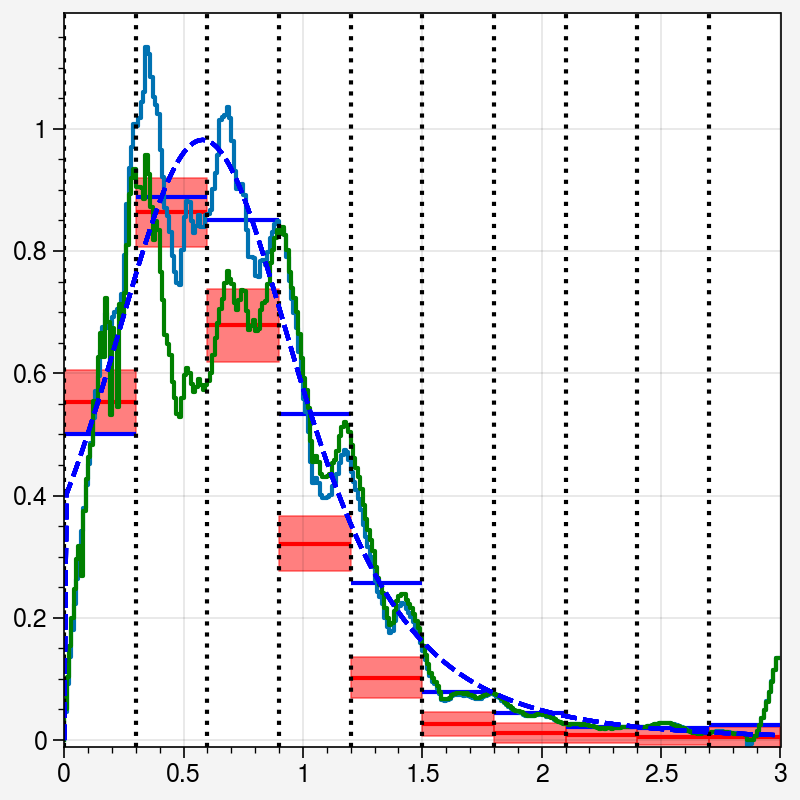

In [61]:
fmod = fmodel_mstudt4(
    ZVALS,
    map_params["a0"],
    map_params["a1"],
    map_params["a2"],
    map_params["a3"],
    map_params["a4"],
    params_nontomo[0][0],
    params_nontomo[0][1],
)
gmod = map_params["g"] * gmodel_template_cosmos()
ngamma = (1.0 + fmod) * nz_nontomo + gmod
ngamma = jnp.clip(ngamma, 0.0, jnp.inf)

fig, axs = pplt.subplots(figsize=(4, 4))

ax = axs[0, 0]
ax.plot(ZVALS, nz_nontomo, drawstyle="steps", label="nontomo")
ax.plot(ZVALS, ngamma, drawstyle="steps", label="nontomo", color="green")
for i in range(10):
    msk = sdata["alpha"] == i
    bin_zmin = sdata["zlow"][msk][0]
    bin_zmax = min(sdata["zhigh"][msk][0], 3.0)
    bin_dz = bin_zmax - bin_zmin
    ax.hlines(sdata["N_mean"][msk] / bin_dz, sdata["zlow"][msk], min(sdata["zhigh"][msk], 3.0), color="red")
    ax.fill_between(
        np.array([bin_zmin, bin_zmax]),
        sdata["N_mean"][msk] / bin_dz - np.sqrt(sdata["N_cov"][msk]) / bin_dz * 10,
        sdata["N_mean"][msk] / bin_dz + np.sqrt(sdata["N_cov"][msk]) / bin_dz * 10,
        color="red",
        alpha=0.5,
    )
    ax.axvline(bin_zmin, color="black", linestyle="dotted")

    msk = (ZVALS >= bin_zmin) & (ZVALS < bin_zmax)
    ng_val = jnp.trapezoid(nz_nontomo[msk], dx=DZ) / bin_dz
    ax.hlines(ng_val, bin_zmin, bin_zmax, color="blue")

    ax.plot(ZVALS, mstudt_nrm(ZVALS, *params_nontomo[0]) / DZ, linestyle="dashed", color="blue")